# Tyche Example with Simple PV Model

## Set up.

### One only needs to execute the following line once, in order to make sure recent enough packages are installed.

In [1]:
#pip install numpy>=1.17.2 pandas>=0.25.1

### Import packages.

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath("../../../src"))

In [3]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import re                as re
import scipy.stats       as st
import seaborn           as sb

# The `tyche` package is located at <https://github.com/NREL/portfolio/tree/master/production-function/framework/src/tyche/>.
import tyche             as ty

from copy import deepcopy

## Load data.

### The data are stored in a set of tab-separated value files in a folder.

In [4]:
designs = ty.Designs(path = ".",
                     name = 'utility-pv.xlsx')

In [5]:
investments = ty.Investments(path = ".",
                             name = 'utility-pv.xlsx')

### Compile the production and metric functions for each technology in the dataset.

In [6]:
designs.compile()

## Examine the data.

### The `functions` table specifies where the Python code for each technology resides.

In [7]:
designs.functions

,Style,Model,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
Simple pv,numpy,utility_pv,capital_cost,fixed_cost,production,metrics,NaN


Right now, only the style `numpy` is supported.

### The `indices` table defines the subscripts for variables.

In [8]:
designs.indices

Offset               Description  \
Technology Type    Index                                                  
Simple pv  Capital Other Capital Cost       0        Other Capital Cost   
           Input   Solar Radiation          0           Solar Radiation   
           Metric  GHG                      1  Greenhouse gas emissions   
                   LCOE                     0                      Cost   
           Output  Electricity              0               Electricity   

                                                                                   Notes  
Technology Type    Index                                                                  
Simple pv  Capital Other Capital Cost  Placeholder in case other capital costs are ne...  
           Input   Solar Radiation                                                   NaN  
           Metric  GHG                                                               NaN  
                   LCOE                                                              NaN  
           Output  Electricity                                                       NaN

### The `designs` table contains the cost, input, efficiency, and price data for a scenario.

In [9]:
designs.designs

Value  \
Technology Scenario                Variable          Index                       
Simple pv  Base PV                 Input             Solar Radiation       5.5   
                                   Input efficiency  Solar Radiation     0.152   
                                   Input price       Solar Radiation         0   
                                   Lifetime          Other Capital Cost     20   
                                   Output efficiency Electricity             1   
                                   Output price      Electricity         0.092   
                                   Scale             NaN                  0.05   
           Fast Progress on PV     Input             Solar Radiation       5.5   
                                   Input efficiency  Solar Radiation     0.152   
                                   Input price       Solar Radiation         0   
                                   Lifetime          Other Capital Cost     20   
                                   Output efficiency Electricity             1   
                                   Output price      Electricity         0.092   
                                   Scale             NaN                  0.05   
           Moderate Progress on PV Input             Solar Radiation       5.5   
                                   Input efficiency  Solar Radiation     0.152   
                                   Input price       Solar Radiation         0   
                                   Lifetime          Other Capital Cost     20   
                                   Output efficiency Electricity             1   
                                   Output price      Electricity         0.092   
                                   Scale             NaN                  0.05   
           Slow Progress on PV     Input             Solar Radiation       5.5   
                                   Input efficiency  Solar Radiation     0.152   
                                   Input price       Solar Radiation         0   
                                   Lifetime          Other Capital Cost     20   
                                   Output efficiency Electricity             1   
                                   Output price      Electricity         0.092   
                                   Scale             NaN                  0.05   

                                                                                  Units  \
Technology Scenario                Variable          Index                                
Simple pv  Base PV                 Input             Solar Radiation         kWh/m2/day   
                                   Input efficiency  Solar Radiation                  1   
                                   Input price       Solar Radiation     USD/kWh/m2/day   
                                   Lifetime          Other Capital Cost              yr   
                                   Output efficiency Electricity                      1   
                                   Output price      Electricity                USD/kWh   
                                   Scale             NaN                      module/yr   
           Fast Progress on PV     Input             Solar Radiation         kWh/m2/day   
                                   Input efficiency  Solar Radiation                  1   
                                   Input price       Solar Radiation     USD/kWh/m2/day   
                                   Lifetime          Other Capital Cost              yr   
                                   Output efficiency Electricity                      1   
                                   Output price      Electricity                USD/kWh   
                                   Scale             NaN                      module/yr   
           Moderate Progress on PV Input             Solar Radiation         kWh/m2/day   
                                   Input efficiency  Solar Radiat

### The `parameters` table contains additional techno-economic parameters for each technology.

In [10]:
designs.parameters

Offset  \
Technology Scenario                Parameter                            
Simple pv  Base PV                 Cells per module                 0   
                                   GHG factor for electricity      13   
                                   Module area utilization         12   
                                   Non-silicon materials cost       6   
                                   Plant size                       8   
                                   Polysilicon price                4   
                                   Production yield                11   
                                   Reference plant cost             7   
                                   Reference plant size             9   
                                   Scaling factor                  10   
                                   Silicon utilization              5   
                                   Wafer area                       1   
                                   Wafer density                    3   
                                   Wafer thickness                  2   
           Fast Progress on PV     Cells per module                 0   
                                   GHG factor for electricity      13   
                                   Module area utilization         12   
                                   Non-silicon materials cost       6   
                                   Plant size                       8   
                                   Polysilicon price                4   
                                   Production yield                11   
                                   Reference plant cost             7   
                                   Reference plant size             9   
                                   Scaling factor                  10   
                                   Silicon utilization              5   
                                   Wafer area                       1   
                                   Wafer density                    3   
                                   Wafer thickness                  2   
           Moderate Progress on PV Cells per module                 0   
                                   GHG factor for electricity      13   
                                   Module area utilization         12   
                                   Non-silicon materials cost       6   
                                   Plant size                       8   
                                   Polysilicon price                4   
                                   Production yield                11   
                                   Reference plant cost             7   
                                   Reference plant size             9   
                                   Scaling factor                  10   
                                   Silicon utilization              5   
                                   Wafer area                       1   
                                   Wafer density                    3   
                                   Wafer thickness                  2   
           Slow Progress on PV     Cells per module                 0   
                                   GHG factor for electricity      13   
                                   Module area utilization         12   
                                   Non-silicon materials cost       6   
                                   Plant size                       8   
                                   Polysilicon price                4   
                                   Production yield                11   
                                   Reference plant cost             7   
                                   Reference plant size             9   
                                   Scaling factor                  10   
                                   Silicon utilization              5   
                                   Wafer area   

### The `results` table specifies the units of measure for results of computations.

In [11]:
designs.results

Units Notes
Technology Variable Index                          
Simple pv  Cost     Cost           USD/module   NaN
           Metric   GHG          gCO2e/module   NaN
                    LCOE              USD/kWh   NaN
           Output   Electricity    kWh/module   NaN

### The `tranches` table specifies multually exclusive possibilities for investments: only one `Tranch` may be selected for each `Cateogry`.

In [12]:
investments.tranches

Amount Notes
Category Tranche       Scenario                              
PV R&D   High PV R&D   Fast Progress on PV      1000000   NaN
         Low PV R&D    Slow Progress on PV      3000000   NaN
         Medium PV R&D Moderate Progress on PV  4500000   NaN
         No PV R&D     Base PV                  1500000   NaN

### The `investments` table bundles a consistent set of tranches (one per category) into an overall investment.

In [13]:
investments.investments

,,,Notes
Investment,Category,Tranche,
High R&D Spending,PV R&D,High PV R&D,NaN
Low R&D Spending,PV R&D,Low PV R&D,NaN
Medium R&D Spending,PV R&D,Medium PV R&D,NaN
No R&D Spending,PV R&D,No PV R&D,NaN


## Evaluate the scenarios in the dataset.

In [14]:
scenario_results = designs.evaluate_scenarios(sample_count=1)

Evaluating Simple pv


/Users/tghosh/miniconda3/envs/tyche/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tghosh/Library/CloudStorage/OneDrive-NREL/work_NREL/tyche/src/tyche/Designs.py:393: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  costs   = costs.append(  result.cost  )
/Users/tghosh/Library/CloudStorage/OneDrive-NREL/work_NREL/tyche/src/tyche/Designs.py:394: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputs = outputs.append(result.output)
/Users/tghosh/Library/CloudStorage/OneDrive-NREL/

In [15]:
scenario_results.xs(1, level="Sample", drop_level=False)

Value  \
Technology Scenario                Sample Variable Index                       
Simple pv  Base PV                 1      Cost     Cost         2.396188e+02   
                                          Metric   GHG          4.508260e+06   
                                                   LCOE         2.126042e-02   
                                          Output   Electricity  1.127065e+04   
           Fast Progress on PV     1      Cost     Cost         2.396188e+02   
                                          Metric   GHG          4.508260e+06   
                                                   LCOE         2.126042e-02   
                                          Output   Electricity  1.127065e+04   
           Moderate Progress on PV 1      Cost     Cost         2.396188e+02   
                                          Metric   GHG          4.508260e+06   
                                                   LCOE         2.126042e-02   
                                          Output   Electricity  1.127065e+04   
           Slow Progress on PV     1      Cost     Cost         2.396188e+02   
                                          Metric   GHG          4.508260e+06   
                                                   LCOE         2.126042e-02   
                                          Output   Electricity  1.127065e+04   

                                                                       Units  
Technology Scenario                Sample Variable Index                      
Simple pv  Base PV                 1      Cost     Cost           USD/module  
                                          Metric   GHG          gCO2e/module  
                                                   LCOE              USD/kWh  
                                          Output   Electricity    kWh/module  
           Fast Progress on PV     1      Cost     Cost           USD/module  
                                          Metric   GHG          gCO2e/module  
                                                   LCOE              USD/kWh  
                                          Output   Electricity    kWh/module  
           Moderate Progress on PV 1      Cost     Cost           USD/module  
                                          Metric   GHG          gCO2e/module  
                                                   LCOE              USD/kWh  
                                          Output   Electricity    kWh/module  
           Slow Progress on PV     1      Cost     Cost           USD/module  
                                          Metric   GHG          gCO2e/module  
                                                   LCOE              USD/kWh  
                                          Output   Electricity    kWh/module

### Save results.

#scenario_results.to_csv("output/utility_pv/results.csv")

### Plot GHG Metric

/var/folders/sm/spdh5zkx26v6vh_fk8w7p8456l6sp0/T/ipykernel_45099/2739126723.py:4: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  data=scenario_results.xs(


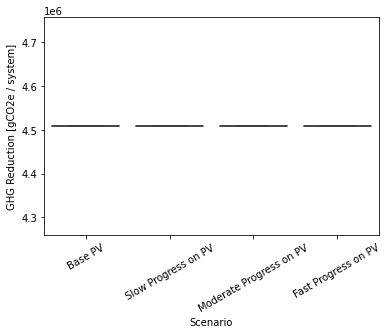

In [16]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "GHG"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "Base PV"              ,
        "Slow Progress on PV"      ,
        "Moderate Progress on PV"  ,
        "Fast Progress on PV"      ,
    ]
)
g.set(ylabel="GHG [gCO2e / module]")
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Plot LCOE Metric

/var/folders/sm/spdh5zkx26v6vh_fk8w7p8456l6sp0/T/ipykernel_45099/2076551106.py:4: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  data=scenario_results.xs(


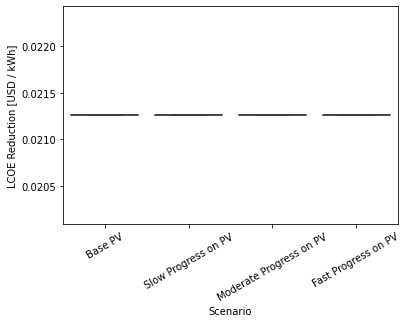

In [17]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "LCOE"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "Base PV"              ,
        "Slow Progress on PV"      ,
        "Moderate Progress on PV"  ,
        "Fast Progress on PV"      ,
    ]
)
g.set(ylabel="LCOE [USD / kWh]")
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Plot cost metric

/var/folders/sm/spdh5zkx26v6vh_fk8w7p8456l6sp0/T/ipykernel_45099/1905123244.py:4: FutureWarning: Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.
  data=scenario_results.xs(


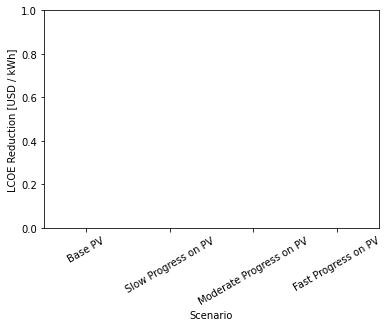

In [18]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "Cost"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=[
        "Base PV"              ,
        "Slow Progress on PV"      ,
        "Moderate Progress on PV"  ,
        "Fast Progress on PV"      ,
    ]
)
g.set(ylabel="LCOE[USD / kWh]")
g.set_xticklabels(g.get_xticklabels(), rotation=30);

### Evaluate the investments in the dataset.

In [19]:
investment_results = investments.evaluate_investments(designs, sample_count=50)

/Users/tghosh/Library/CloudStorage/OneDrive-NREL/work_NREL/tyche/src/tyche/Investments.py:148: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  amounts = self.compiled_tranches.drop(
/Users/tghosh/miniconda3/envs/tyche/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tghosh/miniconda3/envs/tyche/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tghosh/Library/CloudStorage/OneD

Evaluating Simple pv
Evaluating Simple pv


/Users/tghosh/miniconda3/envs/tyche/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tghosh/Library/CloudStorage/OneDrive-NREL/work_NREL/tyche/src/tyche/Designs.py:393: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  costs   = costs.append(  result.cost  )
/Users/tghosh/Library/CloudStorage/OneDrive-NREL/work_NREL/tyche/src/tyche/Designs.py:394: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputs = outputs.append(result.output)
/Users/tghosh/Library/CloudStorage/OneDrive-NREL/

### Cost of investments

In [20]:
investment_results.amounts

,Amount
Investment,
High R&D Spending,1000000.0
Low R&D Spending,3000000.0
Medium R&D Spending,4500000.0
No R&D Spending,1500000.0


### Benefits of investments

In [21]:
investment_results.metrics.xs(1, level="Sample", drop_level=False)

Value  \
Investment          Category Tranche       Scenario                Sample Technology Index                 
No R&D Spending     PV R&D   No PV R&D     Base PV                 1      Simple pv  GHG    4.508260e+06   
                                                                                     LCOE   5.571021e+00   
High R&D Spending   PV R&D   High PV R&D   Fast Progress on PV     1      Simple pv  GHG    4.508260e+06   
                                                                                     LCOE   5.571021e+00   
Medium R&D Spending PV R&D   Medium PV R&D Moderate Progress on PV 1      Simple pv  GHG    4.508260e+06   
                                                                                     LCOE   5.571021e+00   
Low R&D Spending    PV R&D   Low PV R&D    Slow Progress on PV     1      Simple pv  GHG    4.508260e+06   
                                                                                     LCOE   5.571021e+00   

                                                                                                   Units  
Investment          Category Tranche       Scenario                Sample Technology Index                
No R&D Spending     PV R&D   No PV R&D     Base PV                 1      Simple pv  GHG    gCO2e/module  
                                                                                     LCOE        USD/kWh  
High R&D Spending   PV R&D   High PV R&D   Fast Progress on PV     1      Simple pv  GHG    gCO2e/module  
                                                                                     LCOE        USD/kWh  
Medium R&D Spending PV R&D   Medium PV R&D Moderate Progress on PV 1      Simple pv  GHG    gCO2e/module  
                                                                                     LCOE        USD/kWh  
Low R&D Spending    PV R&D   Low PV R&D    Slow Progress on PV     1      Simple pv  GHG    gCO2e/module  
                                                                                     LCOE        USD/kWh

In [22]:
investment_results.summary.xs(1, level="Sample", drop_level=False)

Value         Units
Investment          Technology Sample Index                            
No R&D Spending     Simple pv  1      GHG    4.508260e+06  gCO2e/module
                                      LCOE   5.571021e+00       USD/kWh
High R&D Spending   Simple pv  1      GHG    4.508260e+06  gCO2e/module
                                      LCOE   5.571021e+00       USD/kWh
Medium R&D Spending Simple pv  1      GHG    4.508260e+06  gCO2e/module
                                      LCOE   5.571021e+00       USD/kWh
Low R&D Spending    Simple pv  1      GHG    4.508260e+06  gCO2e/module
                                      LCOE   5.571021e+00       USD/kWh

### Plot GHG metric

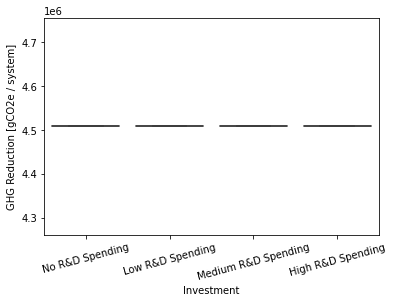

In [25]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "GHG",
        level="Index"
    ).groupby(["Investment", "Sample"]).aggregate(np.sum).reset_index()[["Investment", "Value"]],
    order=[
        "No R&D Spending",
        "Low R&D Spending"   ,
        "Medium R&D Spending",
        "High R&D Spending"  ,
    ]
)
g.set(ylabel="GHG[gCO2e/system]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

### Plot LCOE Metric

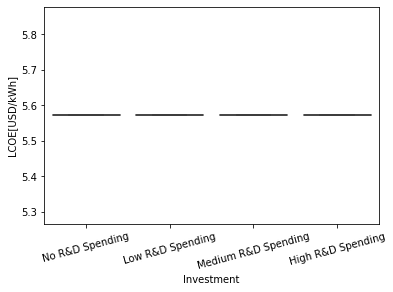

In [26]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "LCOE",
        level="Index"
    ).groupby(["Investment", "Sample"]).aggregate(np.sum).reset_index()[["Investment", "Value"]],
    order=[
        "No R&D Spending",
        "Low R&D Spending"   ,
        "Medium R&D Spending",
        "High R&D Spending"  ,
    ]
)
g.set(ylabel="LCOE[USD/kWh]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

## Multi-objective decision analysis

### Compute costs and metrics for tranches.

In [27]:
tranche_results = investments.evaluate_tranches(designs, sample_count=50)

Evaluating Simple pv


/Users/tghosh/Library/CloudStorage/OneDrive-NREL/work_NREL/tyche/src/tyche/Investments.py:148: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  amounts = self.compiled_tranches.drop(
/Users/tghosh/miniconda3/envs/tyche/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tghosh/miniconda3/envs/tyche/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/tghosh/Library/CloudStorage/OneD

### Display the cost of each tranche.

In [28]:
tranche_results.amounts

Amount
Category Tranche                 
PV R&D   High PV R&D    1000000.0
         Low PV R&D     3000000.0
         Medium PV R&D  4500000.0
         No PV R&D      1500000.0

### Display the metrics for each tranche.

In [29]:
tranche_results.summary

Value         Units
Category Technology Tranche    Sample Index                            
PV R&D   Simple pv  No PV R&D  1      GHG    4.508260e+06  gCO2e/module
                                      LCOE   5.571021e+00       USD/kWh
                               2      GHG    4.508260e+06  gCO2e/module
                                      LCOE   5.571021e+00       USD/kWh
                               3      GHG    4.508260e+06  gCO2e/module
...                                                   ...           ...
                    Low PV R&D 48     LCOE   5.571021e+00       USD/kWh
                               49     GHG    4.508260e+06  gCO2e/module
                                      LCOE   5.571021e+00       USD/kWh
                               50     GHG    4.508260e+06  gCO2e/module
                                      LCOE   5.571021e+00       USD/kWh

[400 rows x 2 columns]

### Fit a response surface to the results.¶

The response surface interpolates between the discrete set of cases provided in the expert elicitation. This allows us to study funding levels intermediate between those scenarios.

In [30]:
evaluator = ty.Evaluator(tranche_results)

Here are the categories of investment and the maximum amount that could be invested in each:

In [31]:
evaluator.max_amount

,Amount
Category,
PV R&D,4500000.0


In [32]:
evaluator.units

,Units
Index,
GHG,gCO2e/module
LCOE,USD/kWh


### Example interpolation.
#### Let's evaluate the case where each category is invested in at half of its maximum amount.

In [33]:
example_investments = evaluator.max_amount / 2
example_investments

,Amount
Category,
PV R&D,2250000.0


In [34]:
evaluator.evaluate(example_investments)

Category  Index  Sample
PV R&D    GHG    1              4508260.416
                 2              4508260.416
                 3              4508260.416
                 4              4508260.416
                 5              4508260.416
                                 ...       
          LCOE   46        5.57102113458035
                 47        5.57102113458035
                 48        5.57102113458035
                 49        5.57102113458035
                 50        5.57102113458035
Name: Value, Length: 100, dtype: object

In [35]:
evaluator.evaluate_statistic(example_investments, np.mean)

Index
GHG     4.508260e+06
LCOE    5.571021e+00
Name: Value, dtype: float64

In [36]:
evaluator.evaluate_statistic(example_investments, np.std)

Index
GHG     0.0
LCOE    0.0
Name: Value, dtype: float64

In [37]:
evaluator.evaluate_statistic(example_investments, lambda x: np.quantile(x, 0.1))

Index
GHG     4.508260e+06
LCOE    5.571021e+00
Name: Value, dtype: float64

### ε-Constraint multiobjective optimization

### Example optimization.

#### Limit spending to $3M.

In [41]:
investment_max = 3e6

In [42]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

### Require that the GHG reduction be at least 40 gCO2e/system and that the Labor wages not decrease.

In [43]:
metric_min = pd.Series([40, 0], name = "Value", index = ["GHG", "Labor"])

### Compute the ε-constrained maximum for the LCOE.

In [45]:
optimum = optimizer.opt_slsqp(
    "LCOE"                       ,
    sense = 'max',
    total_amount = investment_max,
    statistic    = np.mean       ,
)
optimum.exit_message

'Optimization terminated successfully'

In [46]:
np.round(optimum.amounts)

Category
PV R&D    450000.0
Name: Amount, dtype: float64

In [47]:
optimum.metrics

Index
GHG           4508260.416
LCOE    5.571021134580351
Name: Value, dtype: object

In [48]:
np.round(optimum.amounts)

Category
PV R&D    450000.0
Name: Amount, dtype: float64

In [49]:
optimum.metrics

Index
GHG           4508260.416
LCOE    5.571021134580351
Name: Value, dtype: object